# Sentiment Results Analysis

---

## Executive Summary

This notebook explores the output of the NBA Hate Tracker sentiment pipeline: 
1.93M Reddit comments from r/nba (2024-25 season), each classified by sentiment 
(positive/negative/neutral) with player attribution.

### Dataset Quality
- **1,886,133 usable comments** (97.5%) after excluding 48,164 classification errors (2.5%)
- Error comments are systematically different: longer (511 vs ~160 chars), more players mentioned (3.4 vs ~1.4 mean)
- Sentiment distribution: 32.3% negative, 45.0% neutral, 22.7% positive
- Confidence scores bimodal: model is decisive (0.85–0.95) on clear sentiment, defaults to 0.5 on neutral

### Player Attribution
- 92 canonical players tracked via `config/players.yaml`
- **84.1% of usable comments are directly attributable** to a single player
- 5.0% recoverable via normalization map (non-canonical names like "Jokic" → "Nikola Jokic")
- 10.9% ambiguous (multi-player, null sentiment_player) — excluded from player rankings
- Mention distribution follows steep power law: LeBron James leads (~91K), median player ~4K

### Team Flair Extraction
- `config/teams.yaml` maps 30 NBA teams with legacy codes and aliases
- **92.5% of flaired comments** (1.15M of 1.25M) successfully attributed to a team
- Three extraction paths: regex code extraction (73.3%), legacy code mapping (2.7%), alias substring matching (18.7%)
- Excluded: country flairs, conference flairs, SuperSonics (distinct fanbase from OKC)
- All 30 teams represented; Lakers lead volume (150K), Charlotte smallest (5K)

### Team Sentiment Preview
- Dallas Mavericks fans most negative (33.5%) — consistent with Luka Doncic trade fallout
- Oklahoma City Thunder fans least negative (26.6%) and highest positive rate (26.0%) — championship season
- Negativity range is narrow (26.6%–33.5%), suggesting flair differences are real but modest

### Aggregation Design Decisions
- **Reddit score will not be used as a weighting factor.** Median score is 2 across all sentiment classes; mean differences are driven by viral outliers. Equal weight per comment avoids popularity bias.
- **Player normalization** will be config-driven: invert `players.yaml` aliases to map model outputs → canonical names
- **Flair extraction** will use the same alias substring approach validated here

### Data Quality Validation
- Spot-checks confirm labels are broadly accurate across sentiment classes and comment lengths
- Known error patterns (name collisions, idiom misreads) are not systematic
- Consistent with 95.7% accuracy measured in prompt validation (notebook 04)

### Next Steps
- `scripts/aggregate_sentiment.py`: Build player normalization, compute per-player sentiment aggregates with temporal dimension (weekly/monthly bins for bar race chart)
- **Primary deliverable:** Animated bar race chart showing how the most-hated player ranking evolved throughout the 2024-25 season — the centerpiece for the r/nba post
- **Secondary deliverable:** Streamlit dashboard with Leaderboard, Flair View, and Player Detail views
- Pre-compute dashboard views: overall rankings, flair cross-tabs, player detail breakdowns

---

## 1. Dataset Overview

Before diving into sentiment patterns, we establish the basic shape and quality of our classified dataset.

**Questions to answer:**
- Do we have the expected ~1.93M rows?
- What's the date range of comments?
- How prevalent are missing values in key columns?

In [ ]:
import yaml
from datetime import datetime, timedelta

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pl.read_parquet("data/processed/sentiment.parquet")

print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"Memory: {df.estimated_size('mb'):.1f} MB")
print(f"\nSchema:")
for name, dtype in zip(df.columns, df.dtypes):
    print(f"  {name}: {dtype}")

Rows: 1,934,297
Columns: 13
Memory: 557.8 MB

Schema:
  comment_id: String
  body: String
  author: String
  author_flair_text: String
  author_flair_css_class: String
  created_utc: Int64
  score: Int64
  mentioned_players: List(String)
  sentiment: String
  confidence: Float64
  sentiment_player: String
  input_tokens: Int64
  output_tokens: Int64


In [2]:
# Date range
df_with_date = df.with_columns(
    pl.from_epoch("created_utc").alias("created_at")
)

print(f"Earliest comment: {df_with_date['created_at'].min()}")
print(f"Latest comment: {df_with_date['created_at'].max()}")

Earliest comment: 2024-10-01 04:03:41
Latest comment: 2025-06-30 03:59:46


In [3]:
# Missing values in key columns
key_cols = ["sentiment", "confidence", "sentiment_player", "author_flair_text"]

for col in key_cols:
    null_count = df[col].null_count()
    null_pct = null_count / len(df) * 100
    print(f"{col}: {null_count:,} nulls ({null_pct:.2f}%)")

sentiment: 0 nulls (0.00%)
confidence: 0 nulls (0.00%)
sentiment_player: 709,840 nulls (36.70%)
author_flair_text: 687,229 nulls (35.53%)


**Section 1 Findings:**
- Row comments (1.93M) matches expected from Phase 4
- Date range covers full 2024-25 season: pre-season (Oct 1) through Finals (June 22)
- No nulls in classification outputs (`sentiment`, `confidence`) due to error handling defaults
- `author_flair_text` null rate (35.5%) consistent with baseline r/NBA data
- `sentiment_player` has 36.7% nulls — significant; requires investigation

---

## 2. Sentiment Distribution

The classifier assigned each comment one of four labels: `pos`, `neg`, `neu`, or `error` (parse failures).

Initial validation on the pilot showed the following distribution:
| Sentiment | Count | Percentage |
|-----------|-------|------------|
| Neutral | 848,702 | 44% |
| Negative | 609,499 | 31% |
| Positive | 427,932 | 22% |
| Error | 48,164 | 2.5% |

Let's verify these numbers and examine confidence scores by sentiment class.

In [4]:
# Sentiment distribution
sentiment_counts = df.group_by("sentiment").agg(
    pl.len().alias("count")
).with_columns(
    (pl.col("count") / pl.col("count").sum() * 100).alias("percentage")
).sort("count", descending=True)

print(sentiment_counts)

shape: (4, 3)
┌───────────┬────────┬────────────┐
│ sentiment ┆ count  ┆ percentage │
│ ---       ┆ ---    ┆ ---        │
│ str       ┆ u32    ┆ f64        │
╞═══════════╪════════╪════════════╡
│ neu       ┆ 848702 ┆ 43.876509  │
│ neg       ┆ 609499 ┆ 31.510104  │
│ pos       ┆ 427932 ┆ 22.123386  │
│ error     ┆ 48164  ┆ 2.49       │
└───────────┴────────┴────────────┘


In [5]:
# Confidence distribution by sentiment class
confidence_by_sentiment = df.group_by("sentiment").agg(
    pl.col("confidence").mean().alias("mean"),
    pl.col("confidence").median().alias("median"),
    pl.col("confidence").std().alias("std"),
    pl.col("confidence").quantile(0.25).alias("p25"),
    pl.col("confidence").quantile(0.75).alias("p75"),
).sort("mean", descending=True)

print(confidence_by_sentiment)

shape: (4, 6)
┌───────────┬──────────┬────────┬──────────┬──────┬──────┐
│ sentiment ┆ mean     ┆ median ┆ std      ┆ p25  ┆ p75  │
│ ---       ┆ ---      ┆ ---    ┆ ---      ┆ ---  ┆ ---  │
│ str       ┆ f64      ┆ f64    ┆ f64      ┆ f64  ┆ f64  │
╞═══════════╪══════════╪════════╪══════════╪══════╪══════╡
│ pos       ┆ 0.830592 ┆ 0.85   ┆ 0.050006 ┆ 0.8  ┆ 0.85 │
│ neg       ┆ 0.808799 ┆ 0.8    ┆ 0.066681 ┆ 0.75 ┆ 0.85 │
│ neu       ┆ 0.477272 ┆ 0.5    ┆ 0.118829 ┆ 0.5  ┆ 0.5  │
│ error     ┆ 0.0      ┆ 0.0    ┆ 0.0      ┆ 0.0  ┆ 0.0  │
└───────────┴──────────┴────────┴──────────┴──────┴──────┘


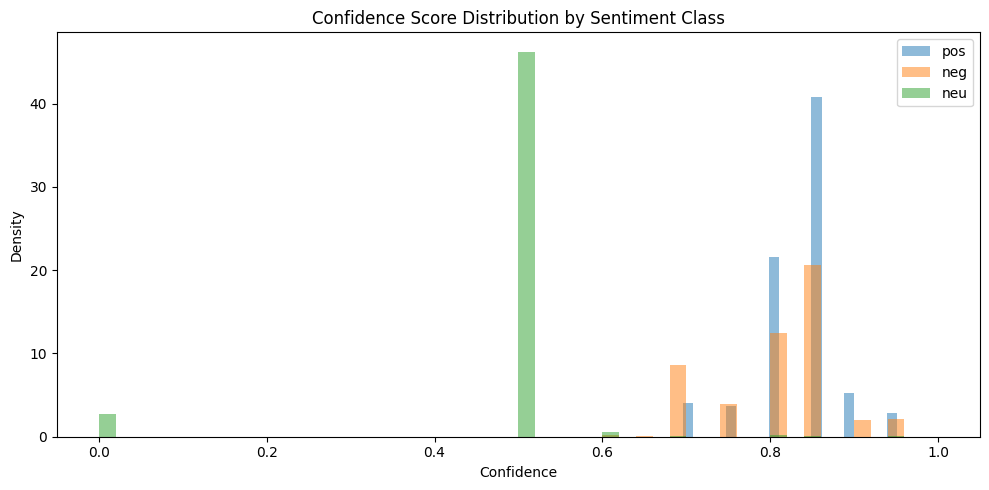

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

for sentiment in ["pos", "neg", "neu"]:
    subset = df.filter(pl.col("sentiment") == sentiment)["confidence"].to_numpy()
    ax.hist(subset, bins=50, alpha=0.5, label=sentiment, density=True)

ax.set_xlabel("Confidence")
ax.set_ylabel("Density")
ax.set_title("Confidence Score Distribution by Sentiment Class")
ax.legend()
plt.tight_layout()
plt.show()

### 2b. Error Analysis

48,164 comments (2.5%) failed to parse. Are these random failures or is there a pattern?

In [7]:
# Sample error cases
errors = df.filter(pl.col("sentiment") == "error")

print(f"Error count: {len(errors):,}")
print(f"\nSample error comments (body preview):\n")

for row in errors.head(10).iter_rows(named=True):
    body_preview = row["body"][:100].replace("\n", " ")
    print(f"- {body_preview}...")
    print(f"  Players: {row['mentioned_players']}")
    print()

Error count: 48,164

Sample error comments (body preview):

- I’d love it if he was a 6th man, but he will not do that. Honestly a 2nd team of Miller/Garza, Randl...
  Players: ['Anthony Edwards', 'Julius Randle']

- The Knicks are pretty well set up to play the aggressive, hedging style MIN did in 2021 when they fi...
  Players: ['OG Anunoby', 'Anthony Edwards', 'Rudy Gobert', 'Josh Hart', 'Karl-Anthony Towns']

- I don’t think the t wolves do that  Also imagine in 2019 someone telling you that the Minnesota timb...
  Players: ['James Harden', 'LeBron James', 'Julius Randle']

- Is cj mccollum the one to go with, contending for a ring this year? Between cj and Bron? How bout ke...
  Players: ['LeBron James', 'Kemba Walker']

- For one, ring is among the most important metric regarding someone's greatness, you play to win the ...
  Players: ['LeBron James']

- nobody scared of Caruso at 3pt, especially playoffs. Chet too and his defense is way too frail to ma...
  Players: ['Alex Carus

In [8]:
# Are errors concentrated in certain players?
error_players = errors.explode("mentioned_players").group_by("mentioned_players").agg(
    pl.len().alias("error_count")
).sort("error_count", descending=True).head(20)

print("Players with most errors:")
print(error_players)

Players with most errors:
shape: (20, 2)
┌─────────────────────────┬─────────────┐
│ mentioned_players       ┆ error_count │
│ ---                     ┆ ---         │
│ str                     ┆ u32         │
╞═════════════════════════╪═════════════╡
│ LeBron James            ┆ 10783       │
│ Luka Doncic             ┆ 8387        │
│ Nikola Jokic            ┆ 8178        │
│ Stephen Curry           ┆ 6770        │
│ Shai Gilgeous-Alexander ┆ 6679        │
│ …                       ┆ …           │
│ Paul George             ┆ 3141        │
│ Victor Wembanyama       ┆ 2935        │
│ Joel Embiid             ┆ 2790        │
│ Karl-Anthony Towns      ┆ 2685        │
│ Chet Holmgren           ┆ 2429        │
└─────────────────────────┴─────────────┘


In [9]:
# Are errors concentrated in time? (bad batch?)
errors_with_date = errors.with_columns(
    pl.from_epoch("created_utc").alias("created_at")
).with_columns(
    pl.col("created_at").dt.date().alias("date")
)

errors_by_date = errors_with_date.group_by("date").agg(
    pl.len().alias("error_count")
).sort("date")

print(f"Date range of errors: {errors_by_date['date'].min()} to {errors_by_date['date'].max()}")
print(f"Days with errors: {len(errors_by_date)}")

Date range of errors: 2024-10-01 to 2025-06-30
Days with errors: 273


In [10]:
# Are error comments longer?
df_with_length = df.with_columns(
    pl.col("body").str.len_chars().alias("body_length"),
    pl.col("mentioned_players").list.len().alias("player_count")
)

length_by_sentiment = df_with_length.group_by("sentiment").agg(
    pl.col("body_length").mean().alias("mean_length"),
    pl.col("body_length").median().alias("median_length"),
    pl.col("player_count").mean().alias("mean_players"),
    pl.col("player_count").median().alias("median_players"),
).sort("mean_length", descending=True)

print(length_by_sentiment)

shape: (4, 5)
┌───────────┬─────────────┬───────────────┬──────────────┬────────────────┐
│ sentiment ┆ mean_length ┆ median_length ┆ mean_players ┆ median_players │
│ ---       ┆ ---         ┆ ---           ┆ ---          ┆ ---            │
│ str       ┆ f64         ┆ f64           ┆ f64          ┆ f64            │
╞═══════════╪═════════════╪═══════════════╪══════════════╪════════════════╡
│ error     ┆ 511.068184  ┆ 403.0         ┆ 3.403434     ┆ 3.0            │
│ neu       ┆ 165.950484  ┆ 106.0         ┆ 1.376493     ┆ 1.0            │
│ neg       ┆ 156.996561  ┆ 99.0          ┆ 1.343247     ┆ 1.0            │
│ pos       ┆ 152.661514  ┆ 91.0          ┆ 1.368509     ┆ 1.0            │
└───────────┴─────────────┴───────────────┴──────────────┴────────────────┘


In [11]:
# Is error rate proportional to player popularity?
# Compare error count to total mentions per player

total_by_player = df.explode("mentioned_players").group_by("mentioned_players").agg(
    pl.len().alias("total_mentions")
)

error_by_player = df.filter(pl.col("sentiment") == "error").explode("mentioned_players").group_by("mentioned_players").agg(
    pl.len().alias("error_count")
)

player_error_rates = total_by_player.join(
    error_by_player, on="mentioned_players", how="left"
).with_columns(
    pl.col("error_count").fill_null(0),
    (pl.col("error_count") / pl.col("total_mentions") * 100).alias("error_rate_pct")
).sort("total_mentions", descending=True).head(20)

print("Error rate for top 20 most-mentioned players:")
print(player_error_rates)

Error rate for top 20 most-mentioned players:
shape: (20, 4)
┌─────────────────────────┬────────────────┬─────────────┬────────────────┐
│ mentioned_players       ┆ total_mentions ┆ error_count ┆ error_rate_pct │
│ ---                     ┆ ---            ┆ ---         ┆ ---            │
│ str                     ┆ u32            ┆ u32         ┆ f64            │
╞═════════════════════════╪════════════════╪═════════════╪════════════════╡
│ LeBron James            ┆ 246729         ┆ 10783       ┆ 4.370382       │
│ Luka Doncic             ┆ 202804         ┆ 8387        ┆ 4.13552        │
│ Nikola Jokic            ┆ 161887         ┆ 8178        ┆ 5.051672       │
│ Shai Gilgeous-Alexander ┆ 132086         ┆ 6679        ┆ 5.056554       │
│ Stephen Curry           ┆ 120932         ┆ 6770        ┆ 5.598187       │
│ …                       ┆ …              ┆ …           ┆ …              │
│ Tyrese Haliburton       ┆ 47423          ┆ 1821        ┆ 3.839909       │
│ Victor Wembanyama       ┆

**Section 2 Findings:**
- Distribution matches Phase 4 exactly — no drift or data loss in processing
- Confidence scores reveal model behavior:
  - `pos`/`neg`: High confidence (0.81-0.83 mean), tight IQR — trustworthy labels
  - `neu`: Centered at exactly 0.5 — model's "uncertain" bucket, not true confidence
  - `error`: 0.0 by design (default on parse failure)
- The 36.7% null rate in `sentiment_player` is distinct from the 2.5% error rate — nulls indicate target ambiguity, not classification failure
- For "most hated" rankings, `neg` classifications are reliable signal

**Section 2b Findings:**
- Errors strongly correlate with comment complexity:
  - Error comments: 511 chars mean, 3.4 players mean
  - Classified comments: ~160 chars mean, ~1.4 players mean
- Error rate varies by player (4-8%), likely because some players appear more often in comparison/ranking discussions
- Errors are *not* randomly distributed, but the bias is toward complex multi-player comments that would be difficult to attribute anyway
- **Aggregation decision:** Exclude errors. The 2.5% loss is acceptable and these comments lack clear sentiment targets.

---

## 3. Temporal Patterns

Let's check for gaps, spikes, and whether sentiment distribution shifts over time.

In [12]:
# Add date columns
df_temporal = df.with_columns(
    pl.from_epoch("created_utc").alias("created_at")
).with_columns(
    pl.col("created_at").dt.date().alias("date"),
    pl.col("created_at").dt.month().alias("month"),
    pl.col("created_at").dt.weekday().alias("weekday"),  # 0=Monday
)

# Daily comment volume
daily_volume = df_temporal.group_by("date").agg(
    pl.len().alias("comments")
).sort("date")

print(f"Total days: {len(daily_volume)}")
print(f"Mean daily comments: {daily_volume['comments'].mean():,.0f}")
print(f"Min: {daily_volume['comments'].min():,} | Max: {daily_volume['comments'].max():,}")

Total days: 273
Mean daily comments: 7,085
Min: 1,211 | Max: 34,038


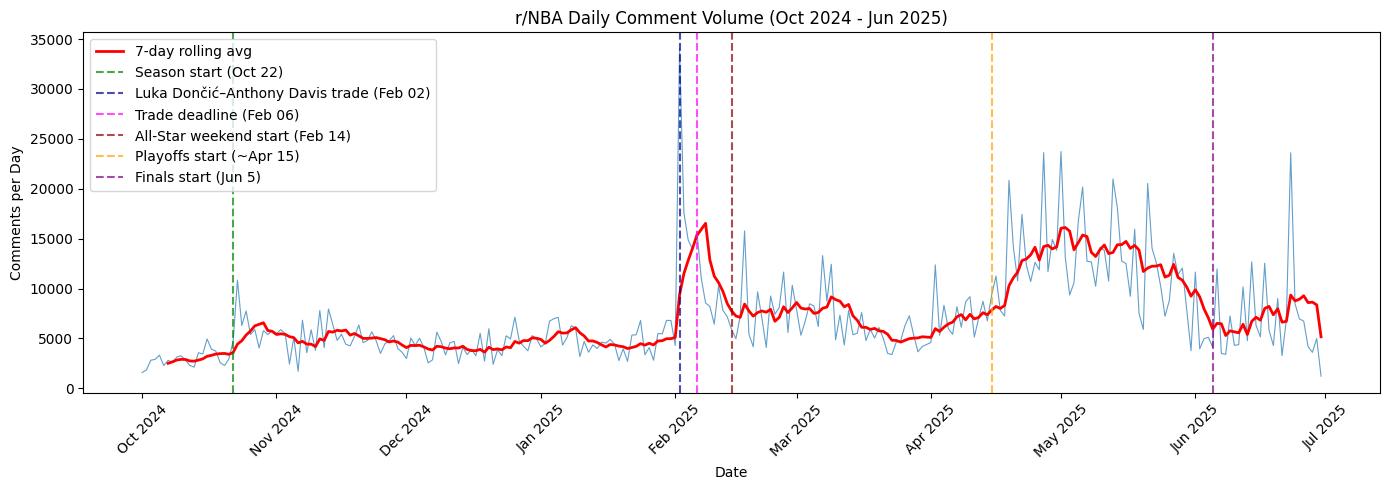

In [13]:
# Daily volume plot
daily_df = daily_volume.to_pandas()
daily_df["date"] = pd.to_datetime(daily_df["date"])

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_df["date"], daily_df["comments"], linewidth=0.8, alpha=0.7)

# Add monthly average as smoothed line
daily_df["rolling_7d"] = daily_df["comments"].rolling(7).mean()
ax.plot(
    daily_df["date"],
    daily_df["rolling_7d"],
    color="red",
    linewidth=2,
    label="7-day rolling avg",
)

# Key dates
ax.axvline(
    pd.Timestamp("2024-10-22"),
    color="green",
    linestyle="--",
    alpha=0.7,
    label="Season start (Oct 22)",
)
ax.axvline(
    pd.Timestamp("2025-02-02"),
    color="darkblue",
    linestyle="--",
    alpha=0.7,
    label="Luka Dončić–Anthony Davis trade (Feb 02)",
)
ax.axvline(
    pd.Timestamp("2025-02-06"),
    color="magenta",
    linestyle="--",
    alpha=0.7,
    label="Trade deadline (Feb 06)",
)
ax.axvline(
    pd.Timestamp("2025-02-14"),
    color="darkred",
    linestyle="--",
    alpha=0.7,
    label="All-Star weekend start (Feb 14)",
)
ax.axvline(
    pd.Timestamp("2025-04-15"),
    color="orange",
    linestyle="--",
    alpha=0.7,
    label="Playoffs start (~Apr 15)",
)
ax.axvline(
    pd.Timestamp("2025-06-05"),
    color="purple",
    linestyle="--",
    alpha=0.7,
    label="Finals start (Jun 5)",
)

ax.set_xlabel("Date")
ax.set_ylabel("Comments per Day")
ax.set_title("r/NBA Daily Comment Volume (Oct 2024 - Jun 2025)")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Sentiment distribution by month - checking for drift
monthly_sentiment = df_temporal.group_by(["month", "sentiment"]).agg(
    pl.len().alias("count")
).sort(["month", "sentiment"])

# Pivot for readability
monthly_pivot = monthly_sentiment.pivot(
    values="count",
    index="month", 
    on="sentiment"
).sort("month")

print(monthly_pivot)

shape: (9, 5)
┌───────┬───────┬────────┬────────┬───────┐
│ month ┆ error ┆ neg    ┆ neu    ┆ pos   │
│ ---   ┆ ---   ┆ ---    ┆ ---    ┆ ---   │
│ i8    ┆ u32   ┆ u32    ┆ u32    ┆ u32   │
╞═══════╪═══════╪════════╪════════╪═══════╡
│ 1     ┆ 4664  ┆ 42368  ┆ 68535  ┆ 35551 │
│ 2     ┆ 6682  ┆ 83557  ┆ 125694 ┆ 60500 │
│ 3     ┆ 4631  ┆ 58751  ┆ 85390  ┆ 45558 │
│ 4     ┆ 6166  ┆ 105364 ┆ 130807 ┆ 69957 │
│ 5     ┆ 8302  ┆ 136554 ┆ 165294 ┆ 82807 │
│ 6     ┆ 5712  ┆ 59736  ┆ 97999  ┆ 41757 │
│ 10    ┆ 4372  ┆ 36480  ┆ 54473  ┆ 27599 │
│ 11    ┆ 3867  ┆ 46718  ┆ 62975  ┆ 34546 │
│ 12    ┆ 3768  ┆ 39971  ┆ 57535  ┆ 29657 │
└───────┴───────┴────────┴────────┴───────┘


In [15]:
# Sentiment ratios by month
monthly_ratios = df_temporal.filter(pl.col("sentiment") != "error").group_by("month").agg(
    pl.len().alias("total"),
    (pl.col("sentiment") == "neg").sum().alias("neg"),
    (pl.col("sentiment") == "pos").sum().alias("pos"),
).with_columns(
    (pl.col("neg") / pl.col("total") * 100).alias("neg_pct"),
    (pl.col("pos") / pl.col("total") * 100).alias("pos_pct"),
    ((pl.col("pos") - pl.col("neg")) / pl.col("total")).alias("net_sentiment"),
).sort("month")

print(monthly_ratios.select(["month", "total", "neg_pct", "pos_pct", "net_sentiment"]))

shape: (9, 5)
┌───────┬────────┬───────────┬───────────┬───────────────┐
│ month ┆ total  ┆ neg_pct   ┆ pos_pct   ┆ net_sentiment │
│ ---   ┆ ---    ┆ ---       ┆ ---       ┆ ---           │
│ i8    ┆ u32    ┆ f64       ┆ f64       ┆ f64           │
╞═══════╪════════╪═══════════╪═══════════╪═══════════════╡
│ 1     ┆ 146454 ┆ 28.92922  ┆ 24.274516 ┆ 29326.344647  │
│ 2     ┆ 269751 ┆ 30.975603 ┆ 22.428091 ┆ 15921.884401  │
│ 3     ┆ 189699 ┆ 30.970643 ┆ 24.015941 ┆ 22640.88953   │
│ 4     ┆ 306128 ┆ 34.418283 ┆ 22.852206 ┆ 14029.856429  │
│ 5     ┆ 384655 ┆ 35.500383 ┆ 21.527603 ┆ 11165.625168  │
│ 6     ┆ 199492 ┆ 29.944058 ┆ 20.931666 ┆ 21529.431341  │
│ 10    ┆ 118552 ┆ 30.771307 ┆ 23.28008  ┆ 36228.477082  │
│ 11    ┆ 144239 ┆ 32.389298 ┆ 23.950527 ┆ 29776.656272  │
│ 12    ┆ 127163 ┆ 31.432885 ┆ 23.322035 ┆ 33775.209629  │
└───────┴────────┴───────────┴───────────┴───────────────┘


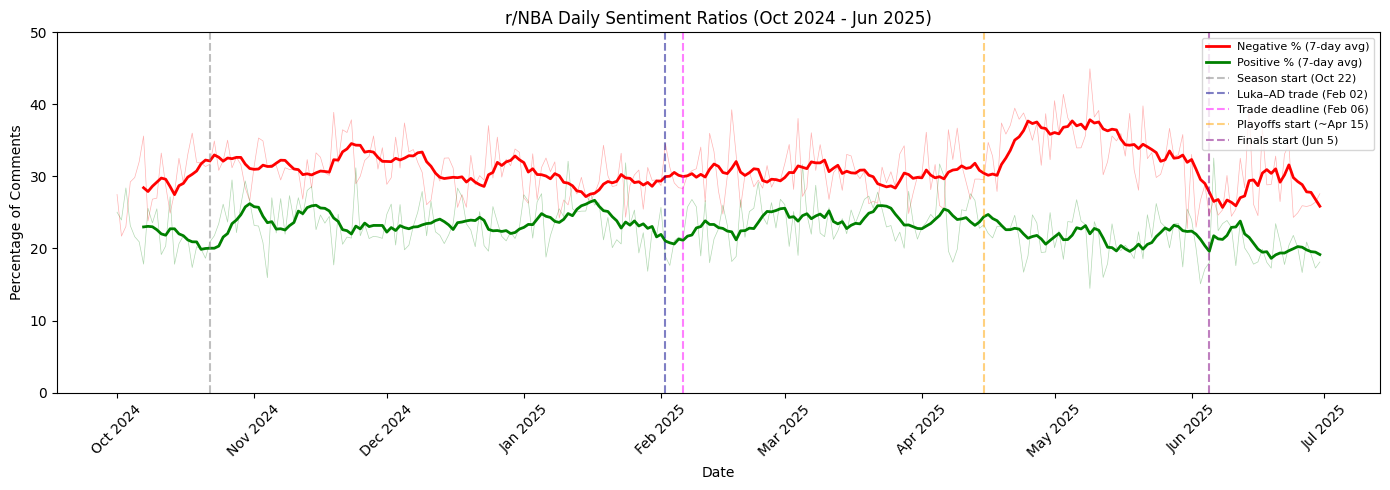

In [16]:
# Daily sentiment ratios
daily_sentiment = df_temporal.filter(pl.col("sentiment") != "error").group_by("date").agg(
    pl.len().alias("total"),
    (pl.col("sentiment") == "neg").sum().alias("neg"),
    (pl.col("sentiment") == "pos").sum().alias("pos"),
).with_columns(
    (pl.col("neg") / pl.col("total") * 100).alias("neg_pct"),
    (pl.col("pos") / pl.col("total") * 100).alias("pos_pct"),
).sort("date")

daily_sent_df = daily_sentiment.to_pandas()
daily_sent_df["date"] = pd.to_datetime(daily_sent_df["date"])
daily_sent_df["neg_rolling_7d"] = daily_sent_df["neg_pct"].rolling(7).mean()
daily_sent_df["pos_rolling_7d"] = daily_sent_df["pos_pct"].rolling(7).mean()

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(daily_sent_df["date"], daily_sent_df["neg_pct"], linewidth=0.5, alpha=0.3, color="red")
ax.plot(daily_sent_df["date"], daily_sent_df["pos_pct"], linewidth=0.5, alpha=0.3, color="green")
ax.plot(daily_sent_df["date"], daily_sent_df["neg_rolling_7d"], linewidth=2, color="red", label="Negative % (7-day avg)")
ax.plot(daily_sent_df["date"], daily_sent_df["pos_rolling_7d"], linewidth=2, color="green", label="Positive % (7-day avg)")

# Key dates
ax.axvline(pd.Timestamp("2024-10-22"), color="gray", linestyle="--", alpha=0.5, label="Season start (Oct 22)")
ax.axvline(pd.Timestamp("2025-02-02"), color="darkblue", linestyle="--", alpha=0.5, label="Luka–AD trade (Feb 02)")
ax.axvline(pd.Timestamp("2025-02-06"), color="magenta", linestyle="--", alpha=0.5, label="Trade deadline (Feb 06)")
ax.axvline(pd.Timestamp("2025-04-15"), color="orange", linestyle="--", alpha=0.5, label="Playoffs start (~Apr 15)")
ax.axvline(pd.Timestamp("2025-06-05"), color="purple", linestyle="--", alpha=0.5, label="Finals start (Jun 5)")

ax.set_xlabel("Date")
ax.set_ylabel("Percentage of Comments")
ax.set_title("r/NBA Daily Sentiment Ratios (Oct 2024 - Jun 2025)")
ax.legend(loc="upper right", fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_ylim(0, 50)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Section 3 Findings:**
- Daily comment volume ranges from 1.2K to 34K with clear event-driven spikes (Luka-AD trade, playoffs)
- Volume variability is a feature, not a bug — reflects genuine engagement patterns
- Sentiment ratios are remarkably stable: ~30% negative, ~22% positive throughout the season
- Playoff period shows elevated negativity (peaks ~38%) — expected as fans react to eliminations
- No classifier drift detected — hate scores computed at different points in the season are directly comparable
- **Race chart feasibility confirmed:** Sufficient volume and stable baselines support weekly/bi-weekly ranking windows

## 4. Player Coverage

Before computing hate scores, we need to understand the mention distribution. How many players have enough data to rank reliably?

In [17]:
# Unique players and mention distribution
# Using sentiment_player where available, otherwise explode mentioned_players

player_mentions = df.filter(
    (pl.col("sentiment") != "error") & (pl.col("sentiment_player").is_not_null())
).group_by("sentiment_player").agg(
    pl.len().alias("mentions")
).sort("mentions", descending=True)

print(f"Unique players with attributable sentiment: {len(player_mentions):,}")
print(f"\nTop 20 most-mentioned players:")
print(player_mentions.head(20))

Unique players with attributable sentiment: 9,792

Top 20 most-mentioned players:
shape: (20, 2)
┌──────────────────┬──────────┐
│ sentiment_player ┆ mentions │
│ ---              ┆ ---      │
│ str              ┆ u32      │
╞══════════════════╪══════════╡
│ LeBron James     ┆ 91629    │
│ Luka Doncic      ┆ 89396    │
│ Jokic            ┆ 44840    │
│ Draymond Green   ┆ 40238    │
│ SGA              ┆ 34034    │
│ …                ┆ …        │
│ Ant              ┆ 16407    │
│ Jimmy Butler     ┆ 14733    │
│ Kawhi Leonard    ┆ 14362    │
│ Kyrie Irving     ┆ 13363    │
│ Anthony Davis    ┆ 13136    │
└──────────────────┴──────────┘


In [18]:
# Distribution shape - is it power law?
print(f"\nMention distribution:")
print(f"  Max: {player_mentions['mentions'].max():,}")
print(f"  Median: {player_mentions['mentions'].median():,}")
print(f"  Mean: {player_mentions['mentions'].mean():,.0f}")
print(f"  Min: {player_mentions['mentions'].min():,}")

# How many players above various thresholds?
for threshold in [100, 500, 1000, 5000, 10000]:
    count = player_mentions.filter(pl.col("mentions") >= threshold).shape[0]
    print(f"  Players with >= {threshold:,} mentions: {count}")


Mention distribution:
  Max: 91,629
  Median: 1.0
  Mean: 125
  Min: 1
  Players with >= 100 mentions: 434
  Players with >= 500 mentions: 171
  Players with >= 1,000 mentions: 130
  Players with >= 5,000 mentions: 55
  Players with >= 10,000 mentions: 32


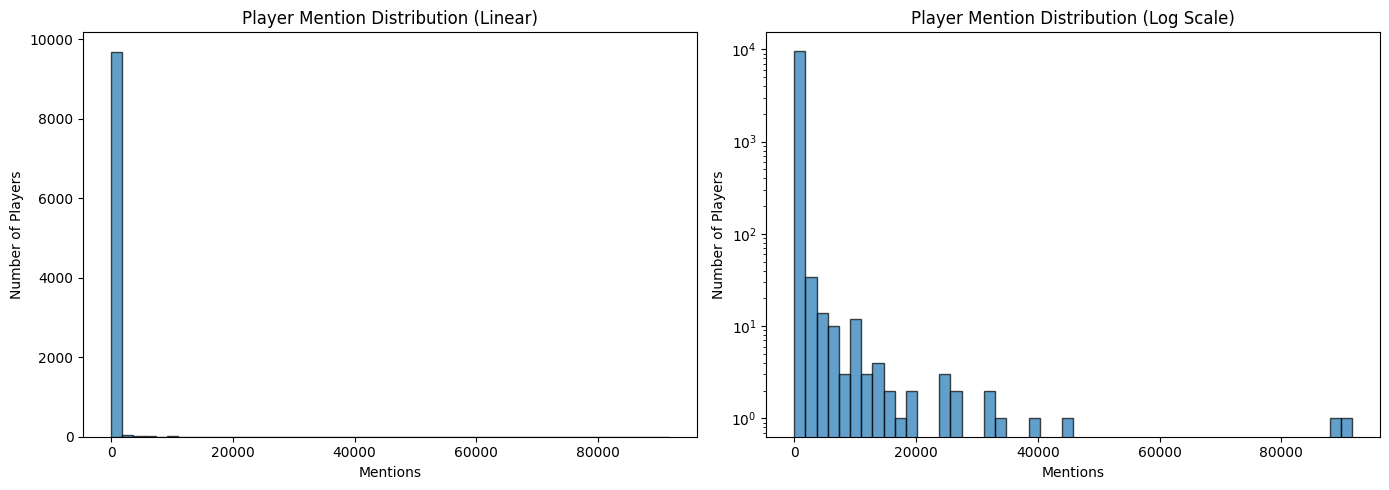

In [19]:
# Visualize the long tail
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
mentions_arr = player_mentions["mentions"].to_numpy()
axes[0].hist(mentions_arr, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Mentions")
axes[0].set_ylabel("Number of Players")
axes[0].set_title("Player Mention Distribution (Linear)")

# Log scale to see the tail
axes[1].hist(mentions_arr, bins=50, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Mentions")
axes[1].set_ylabel("Number of Players")
axes[1].set_title("Player Mention Distribution (Log Scale)")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [20]:
# How many sentiment_player values match canonical names from mentioned_players?
# Get all canonical names from the dataset
canonical_names = df.explode("mentioned_players").select("mentioned_players").unique().to_series().to_list()
canonical_names = [n for n in canonical_names if n is not None]

print(f"Canonical player names in dataset: {len(canonical_names)}")

# How many sentiment_player values are already canonical?
sentiment_players = player_mentions["sentiment_player"].to_list()
canonical_matches = [p for p in sentiment_players if p in canonical_names]
print(f"sentiment_player values that are canonical: {len(canonical_matches)}")
print(f"sentiment_player values needing normalization: {len(sentiment_players) - len(canonical_matches)}")

Canonical player names in dataset: 92
sentiment_player values that are canonical: 92
sentiment_player values needing normalization: 9700


In [ ]:
# What are the top non-canonical sentiment_player values?
non_canonical = player_mentions.filter(~pl.col("sentiment_player").is_in(canonical_names))
print(f"\nTop 30 non-canonical sentiment_player values:")
print(non_canonical.head(30))


Top 30 non-canonical sentiment_player values:
shape: (30, 2)
┌──────────────────┬──────────┐
│ sentiment_player ┆ mentions │
│ ---              ┆ ---      │
│ str              ┆ u32      │
╞══════════════════╪══════════╡
│ Jokic            ┆ 44840    │
│ SGA              ┆ 34034    │
│ Steph Curry      ┆ 24948    │
│ Ant              ┆ 16407    │
│ Bronny James     ┆ 11614    │
│ …                ┆ …        │
│ Mitchell         ┆ 2818     │
│ Gordon           ┆ 2641     │
│ Garland          ┆ 2453     │
│ Turner           ┆ 2404     │
│ Reaves           ┆ 2387     │
└──────────────────┴──────────┘


In [22]:
# How much data is recoverable with each approach?

# Single-player comments (use mentioned_players directly)
single_player = df.filter(
    (pl.col("sentiment") != "error") & 
    (pl.col("mentioned_players").list.len() == 1)
)
print(f"Single-player comments: {len(single_player):,} ({len(single_player)/len(df)*100:.1f}%)")

# Multi-player comments with canonical sentiment_player
multi_with_canonical = df.filter(
    (pl.col("sentiment") != "error") & 
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_in(canonical_names))
)
print(f"Multi-player with canonical sentiment_player: {len(multi_with_canonical):,} ({len(multi_with_canonical)/len(df)*100:.1f}%)")

# Multi-player with non-canonical sentiment_player (needs normalization)
multi_non_canonical = df.filter(
    (pl.col("sentiment") != "error") & 
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_not_null()) &
    (~pl.col("sentiment_player").is_in(canonical_names))
)
print(f"Multi-player with non-canonical sentiment_player: {len(multi_non_canonical):,} ({len(multi_non_canonical)/len(df)*100:.1f}%)")

# Multi-player with null sentiment_player (unattributable)
multi_null = df.filter(
    (pl.col("sentiment") != "error") & 
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_null())
)
print(f"Multi-player with null sentiment_player: {len(multi_null):,} ({len(multi_null)/len(df)*100:.1f}%)")

Single-player comments: 1,402,496 (72.5%)
Multi-player with canonical sentiment_player: 184,116 (9.5%)
Multi-player with non-canonical sentiment_player: 93,699 (4.8%)
Multi-player with null sentiment_player: 205,822 (10.6%)


**Section 4 Findings:**
- 92 canonical players appear in `mentioned_players` (from config)
- 9,792 unique values in `sentiment_player` — heavy fragmentation from model outputs
- Mention distribution follows steep power law: median 1, mean 125, max 91K
- 32 players have 10K+ mentions; 130 have 1K+ — sufficient for reliable rankings

**Attribution breakdown:**
| Category | Comments | % | Aggregation Strategy |
|----------|----------|---|----------------------|
| Single-player | 1,402,496 | 72.5% | Use `mentioned_players[0]` directly |
| Multi-player, canonical `sentiment_player` | 184,116 | 9.5% | Use as-is |
| Multi-player, non-canonical `sentiment_player` | 93,699 | 4.8% | Requires normalization map |
| Multi-player, null `sentiment_player` | 205,822 | 10.6% | Exclude from player rankings |

**Aggregation decision:** Build normalization map for top ~50 non-canonical names (Jokic, SGA, Steph, Ant, etc.) to recover the 4.8%. Accept 10.6% loss on null multi-player comments.

## 5. Team Flair Analysis

Reddit flair indicates team allegiance. This enables segmented analysis: "What do Lakers fans think of LeBron?" or "Which fanbase is most negative overall?"

The raw `author_flair_text` field contains formatting artifacts (`:lal-1: Lakers`, `:lal-2: Lakers`, etc.) that need normalization to team names before analysis.

In [24]:
# What are we working with?
flair_counts = df.group_by("author_flair_text").agg(
    pl.len().alias("count")
).sort("count", descending=True)

print(f"Unique author_flair_text values: {len(flair_counts):,}")
print(f"Null flairs: {df['author_flair_text'].null_count():,} ({df['author_flair_text'].null_count()/len(df)*100:.1f}%)")
print(f"\nTop 50 flair values:")
print(flair_counts.head(50))

Unique author_flair_text values: 1,850
Null flairs: 687,229 (35.5%)

Top 50 flair values:
shape: (50, 2)
┌────────────────────────────────┬────────┐
│ author_flair_text              ┆ count  │
│ ---                            ┆ ---    │
│ str                            ┆ u32    │
╞════════════════════════════════╪════════╡
│ null                           ┆ 687229 │
│ :lal-1: Lakers                 ┆ 58209  │
│ :lal-2: Lakers                 ┆ 42514  │
│ :min-1: Timberwolves           ┆ 33756  │
│ :gsw-1: Warriors               ┆ 32712  │
│ …                              ┆ …      │
│ :sac-4: Kings                  ┆ 6879   │
│ :gsw-3: San Francisco Warriors ┆ 6832   │
│ :min-5: Timberwolves           ┆ 6683   │
│ :det-4: Pistons                ┆ 6464   │
│ :atl-1: Hawks                  ┆ 6454   │
└────────────────────────────────┴────────┘


In [25]:
# Look at the tail too - what's the noise?
print("Bottom 30 flair values (noise check):")
print(flair_counts.filter(pl.col("count") > 1).tail(30))

Bottom 30 flair values (noise check):
shape: (30, 2)
┌──────────────────────┬───────┐
│ author_flair_text    ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ [MIA] Chris Andersen ┆ 2     │
│ [PHI] Theo Ratliff   ┆ 2     │
│ Nando de Colo        ┆ 2     │
│ [MIA] Norris Cole    ┆ 2     │
│ [MIL] Yi Jianlian    ┆ 2     │
│ …                    ┆ …     │
│ [OKC] Taj Gibson     ┆ 2     │
│ [BOS] Dino Radja     ┆ 2     │
│ [DEN] Malik Beasley  ┆ 2     │
│ [BOS] Robert Parish  ┆ 2     │
│ [ATL] Josh Smith     ┆ 2     │
└──────────────────────┴───────┘


### What patterns exist in the flair strings?

In [26]:
# Let's look at the structure, not just the values

non_null_flairs = df.filter(pl.col("author_flair_text").is_not_null())

# Sample diverse flairs to understand formatting patterns
sample_flairs = (
    non_null_flairs
    .select("author_flair_text")
    .unique()
    .sample(n=min(100, non_null_flairs.select("author_flair_text").unique().height), seed=42)
    .sort("author_flair_text")
)

print(f"Unique non-null flair values: {non_null_flairs.select('author_flair_text').unique().height:,}")
print(f"\nSample of 100 unique flairs (sorted):")
for row in sample_flairs.iter_rows():
    print(f"  '{row[0]}'")

Unique non-null flair values: 1,849

Sample of 100 unique flairs (sorted):
  ':atl-1: Hawks'
  ':atl-2: Hawks'
  ':bkn-1: [BKN[ Kyrie Irving'
  ':bos-1: [BOS] Jaylen Brown'
  ':bos-1: [BOS] Marcus Smart'
  ':bos-4: [BOS] Marcus Smart'
  ':bw-atl: Hawks Bandwagon'
  ':bw-chi: Bulls Bandwagon'
  ':bw-lal: Lakers Bandwagon'
  ':dal-4: [DAL] Luka Doncic'
  ':den-5: [DEN] Peyton Watson'
  ':gsw-1: [GSW] Andre Iguodala'
  ':hou-5: Rockets'
  ':lal-1: [LAL] Gary Payton'
  ':lal-1: [LAL] Steve Blake'
  ':lal-4: Minneapolis Lakers'
  ':lal-4: [LAL] Kobe Bryant'
  ':mem-1: Grizzlies'
  ':mem-2: Grizzlies'
  ':min-1: Timberwolves [MIN] Naz Reid - Jaden McDaniels'
  ':mke-4: Bucks'
  ':mke-5: Bucks'
  ':nol-1: [NOL] Jrue Holiday'
  ':orl-1: Magic'
  ':phi-1: 76ers'
  ':phi-3: 76ers [PHI] Tyrese Maxey'
  ':phi-3: [PHI] Matisse Thybulle'
  ':por-5: [PDX] Toumani Camara'
  ':sas-5: Spurs [SAS] Keldon Johnson'
  ':sea-3: Supersonics [SEA] Kevin Durant'
  ':tbr-1: [TOR] Kawhi Leonard'
  ':tor-4: [TOR] 

### 5a. Flair Pattern Discovery

Before building team extraction logic, we need to understand the formatting patterns
in `author_flair_text`. Raw flair values contain emoji prefixes, team codes, player 
names, and bandwagon variants — all of which need to resolve to a canonical team name.

Our sample of unique flairs reveals three distinct patterns:
1. **Emoji-prefix:** `:lal-1: Lakers`, `:bos-4: [BOS] Marcus Smart`
2. **Bracket-prefix:** `[MIA] Chris Andersen` (no emoji prefix)
3. **Plain text:** `Lakers`, `Celtics Bandwagon`, `:AUS: Australia`

All three patterns embed a team identifier — either as a short code (`lal`, `DAL`) or 
a team name (`Lakers`). Let's quantify how much of the data each pattern covers and 
extract the codes programmatically.

In [27]:
# Categorize flair patterns with regex
flair_values = (
    df.filter(pl.col("author_flair_text").is_not_null())
    .group_by("author_flair_text")
    .agg(pl.len().alias("count"))
)

# Pattern 1: Emoji-prefix team flairs like ":lal-1: Lakers"
emoji_prefix = flair_values.filter(
    pl.col("author_flair_text").str.contains(r"^:[a-z]{3}-\d+:")
)

# Pattern 2: Bracket-prefix player flairs like "[MIA] Chris Andersen"
bracket_prefix = flair_values.filter(
    pl.col("author_flair_text").str.contains(r"^\[[A-Z]{3}\]")
)

# Pattern 3: Everything else
other = flair_values.filter(
    ~pl.col("author_flair_text").str.contains(r"^:[a-z]{3}-\d+:") &
    ~pl.col("author_flair_text").str.contains(r"^\[[A-Z]{3}\]")
)

emoji_comments = emoji_prefix["count"].sum()
bracket_comments = bracket_prefix["count"].sum()
other_comments = other["count"].sum()
total_flaired = emoji_comments + bracket_comments + other_comments

print(f"Flair pattern breakdown:")
print(f"  Emoji-prefix (:lal-1: Lakers):  {emoji_prefix.height:,} unique, {emoji_comments:,} comments ({emoji_comments/total_flaired*100:.1f}%)")
print(f"  Bracket-prefix ([MIA] Player):  {bracket_prefix.height:,} unique, {bracket_comments:,} comments ({bracket_comments/total_flaired*100:.1f}%)")
print(f"  Other:                          {other.height:,} unique, {other_comments:,} comments ({other_comments/total_flaired*100:.1f}%)")

print(f"\nOther patterns (inspect for additional formats):")
print(other.sort("count", descending=True).head(30))

Flair pattern breakdown:
  Emoji-prefix (:lal-1: Lakers):  534 unique, 925,383 comments (74.2%)
  Bracket-prefix ([MIA] Player):  1,083 unique, 65,488 comments (5.3%)
  Other:                          232 unique, 256,197 comments (20.5%)

Other patterns (inspect for additional formats):
shape: (30, 2)
┌───────────────────┬───────┐
│ author_flair_text ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ Lakers            ┆ 22350 │
│ Celtics           ┆ 18748 │
│ Warriors          ┆ 17084 │
│ Thunder           ┆ 15052 │
│ Knicks            ┆ 11605 │
│ …                 ┆ …     │
│ Kings             ┆ 3363  │
│                   ┆ 3096  │
│ :AUS: Australia   ┆ 2962  │
│ :CAN: Canada      ┆ 2719  │
│ Magic             ┆ 2610  │
└───────────────────┴───────┘


**Pattern breakdown:**
- Emoji-prefix covers 74.2% of flaired comments — the dominant format
- Bracket-prefix adds 5.3% — player-specific flairs with team codes
- Plain text accounts for 20.5% — includes team names, bandwagon, and country flairs

All three patterns contain a parseable team identifier. The emoji and bracket patterns 
embed 2-4 letter codes (`:lal-`, `[DAL]`, `:bw-chi:`) that we can extract with regex.
Plain text flairs will require substring matching against known team names.

Let's extract all codes from the prefix patterns and see what we're working with.

---


### 5b. Team Code Extraction

We extract short codes from flair prefixes using three regex patterns:
- `:xxx-N:` — standard emoji prefix (e.g., `:lal-1:` → `LAL`)
- `:bw-xxx:` — bandwagon prefix (e.g., `:bw-lal:` → `LAL`)
- `[XXX]` — bracket prefix (e.g., `[DAL]` → `DAL`)

This should capture ~80% of flaired comments. The remainder will need 
alias-based matching in the aggregation step.

In [ ]:
# Extract three-letter codes from flair prefixes
# Covers both :xxx-N: and [XXX] patterns
code_extraction = (
    df.filter(pl.col("author_flair_text").is_not_null())
    .with_columns(
        # Extract from emoji prefix :xxx-N: (lowercase)
        pl.col("author_flair_text")
        .str.extract(r"^:(\w{2,4})-\d+:", 1)
        .alias("emoji_code"),
        # Extract from bracket prefix [XXX] (uppercase)
        pl.col("author_flair_text")
        .str.extract(r"^\[([A-Z]{3})\]", 1)
        .alias("bracket_code"),
        # Extract from bandwagon :bw-xxx: 
        pl.col("author_flair_text")
        .str.extract(r"^:bw-(\w{2,4}):", 1)
        .alias("bandwagon_code"),
    )
    .with_columns(
        # Unify: prefer emoji, then bandwagon, then bracket
        pl.coalesce(["emoji_code", "bandwagon_code", "bracket_code"])
        .str.to_uppercase()
        .alias("extracted_code")
    )
)

# What codes did we extract?
code_counts = (
    code_extraction
    .filter(pl.col("extracted_code").is_not_null())
    .group_by("extracted_code")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

print(f"Unique codes extracted: {code_counts.height}")
print(f"Comments with extracted code: {code_counts['count'].sum():,}")
print(f"\nAll extracted codes:")
print(code_counts)

# What's left unmatched?
no_code = code_extraction.filter(
    pl.col("extracted_code").is_null()
)
no_code_counts = (
    no_code
    .group_by("author_flair_text")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)
print(f"\nUnmatched flairs (no code extracted): {no_code.height:,} comments")
print(f"Top 30 unmatched:")
print(no_code_counts.head(30))

Unique codes extracted: 47
Comments with extracted code: 1,001,074

All extracted codes:
shape: (47, 2)
┌────────────────┬────────┐
│ extracted_code ┆ count  │
│ ---            ┆ ---    │
│ str            ┆ u32    │
╞════════════════╪════════╡
│ LAL            ┆ 126880 │
│ GSW            ┆ 71830  │
│ BOS            ┆ 69640  │
│ OKC            ┆ 68311  │
│ NYK            ┆ 53231  │
│ …              ┆ …      │
│ NJN            ┆ 228    │
│ GFL            ┆ 184    │
│ BRK            ┆ 104    │
│ CHO            ┆ 66     │
│ PDX            ┆ 20     │
└────────────────┴────────┘

Unmatched flairs (no code extracted): 245,994 comments
Top 30 unmatched:
shape: (30, 2)
┌───────────────────┬───────┐
│ author_flair_text ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ Lakers            ┆ 22350 │
│ Celtics           ┆ 18748 │
│ Warriors          ┆ 17084 │
│ Thunder           ┆ 15052 │
│ Knicks            ┆ 11605 │
│ …                 ┆ …     │
│

In [31]:
# Separate NBA team codes from non-team codes
# Known NBA abbreviations (current)
nba_abbreviations = {
    "ATL", "BOS", "BKN", "CHA", "CHI", "CLE", "DAL", "DEN", "DET", "GSW",
    "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOP", "NYK",
    "OKC", "ORL", "PHI", "PHX", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"
}

all_codes = code_counts["extracted_code"].to_list()
team_codes = [c for c in all_codes if c in nba_abbreviations]
non_team_codes = [c for c in all_codes if c not in nba_abbreviations]

print(f"Matched to current NBA teams: {len(team_codes)}/30")
print(f"Missing NBA teams: {nba_abbreviations - set(team_codes)}")
print(f"\nNon-team codes ({len(non_team_codes)}):")
for code in non_team_codes:
    count = code_counts.filter(pl.col("extracted_code") == code)["count"].item()
    print(f"  {code}: {count:,} comments")

Matched to current NBA teams: 30/30
Missing NBA teams: set()

Non-team codes (17):
  NBA: 30,998 comments
  MKE: 21,749 comments
  SEA: 13,122 comments
  NOL: 8,946 comments
  WC: 4,553 comments
  TBR: 2,366 comments
  EC: 898 comments
  GD: 882 comments
  PHO: 793 comments
  VOTE: 769 comments
  YC: 530 comments
  SP8: 286 comments
  NJN: 228 comments
  GFL: 184 comments
  BRK: 104 comments
  CHO: 66 comments
  PDX: 20 comments


### 5c. Non-Team Code Investigation

Code extraction found 47 unique codes — 30 matching current NBA teams and 17 others.
Several are recognizable as legacy team abbreviations (MKE, NOL, PHO, BRK, CHO, PDX, NJN).
Others need inspection before we decide whether to map, exclude, or bucket them.

In [32]:
# Inspect the non-team codes we haven't identified yet
unknown_codes = ["WC", "EC", "TBR", "GD", "VOTE", "YC", "SP8", "GFL"]

for code in unknown_codes:
    sample = (
        code_extraction
        .filter(pl.col("extracted_code") == code)
        .select("author_flair_text")
        .unique()
        .sort("author_flair_text")
    )
    count = code_counts.filter(pl.col("extracted_code") == code)["count"].item()
    print(f"\n{code} — {count:,} comments ({sample.height} unique flairs):")
    for row in sample.iter_rows():
        print(f"  '{row[0]}'")


WC — 4,553 comments (1 unique flairs):
  ':wc-1: West'

EC — 898 comments (1 unique flairs):
  ':ec-1: East'

TBR — 2,366 comments (6 unique flairs):
  ':tbr-1: Tampa Bay Raptors'
  ':tbr-1: [TOR] Kawhi Leonard'
  ':tbr-2: Tampa Bay Raptors'
  ':tbr-3: Tampa Bay Raptors'
  ':tbr-4: Tampa Bay Raptors'
  ':tbr-5: Tampa Bay Raptors'

GD — 882 comments (1 unique flairs):
  ':gd-1: Gran Destino'

VOTE — 769 comments (5 unique flairs):
  ':vote-1:'
  ':vote-1: Registered to Vote'
  ':vote-1:Mavericks'
  ':vote-1:Pelicans'
  ':vote-1:Supersonics'

YC — 530 comments (1 unique flairs):
  ':yc-1: Yacht Club'

SP8 — 286 comments (1 unique flairs):
  ':sp8-1: Super 8'

GFL — 184 comments (1 unique flairs):
  ':gfl-1: Grand Floridian'


**Non-team code findings:**

| Code | Meaning | Comments | Decision |
|------|---------|----------|----------|
| MKE | Legacy Milwaukee | 21,749 | Map → MIL |
| SEA | Seattle SuperSonics | 13,122 | Exclude (distinct fanbase) |
| NOL | Legacy New Orleans | 8,946 | Map → NOP |
| TBR | Tampa Bay Raptors (COVID) | 2,366 | Map → TOR |
| PHO | Legacy Phoenix | 793 | Map → PHX |
| NJN | New Jersey Nets | 228 | Map → BKN |
| BRK | Alternate Brooklyn | 104 | Map → BKN |
| CHO | Charlotte (Bobcats era) | 66 | Map → CHA |
| PDX | Portland area code | 20 | Map → POR |
| NBA | League flair | 30,998 | Exclude (no affiliation) |
| WC/EC | Conference flairs | 5,451 | Exclude |
| GD, YC, SP8, GFL | Disney bubble hotels | 1,882 | Exclude |
| VOTE | Election campaign | 769 | Exclude |

**Recovery:** 6 legacy codes map to current teams (34,087 comments). 
Non-team codes excluded: ~52K comments (acceptable loss).

In [33]:
# What plain-text flairs need alias matching?
# These are the ~246K unmatched comments from earlier

# Get all unmatched, non-empty flairs
unmatched_flairs = (
    no_code_counts
    .filter(
        (pl.col("author_flair_text") != "") & 
        (pl.col("author_flair_text").is_not_null())
    )
    .sort("count", descending=True)
)

print(f"Unique unmatched flair values: {unmatched_flairs.height}")
print(f"Total unmatched comments: {unmatched_flairs['count'].sum():,}")
print(f"\nAll unmatched flairs with 100+ comments:")
print(unmatched_flairs.filter(pl.col("count") >= 100))

print(f"\nTail (under 100 comments):")
remaining = unmatched_flairs.filter(pl.col("count") < 100)
print(f"  {remaining.height} unique values, {remaining['count'].sum():,} total comments")

Unique unmatched flair values: 198
Total unmatched comments: 242,898

All unmatched flairs with 100+ comments:
shape: (74, 2)
┌────────────────────┬───────┐
│ author_flair_text  ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ Lakers             ┆ 22350 │
│ Celtics            ┆ 18748 │
│ Warriors           ┆ 17084 │
│ Thunder            ┆ 15052 │
│ Knicks             ┆ 11605 │
│ …                  ┆ …     │
│ Brazil             ┆ 135   │
│ Rockets Bandwagon  ┆ 124   │
│ San Diego Clippers ┆ 120   │
│ :GEO: Georgia      ┆ 112   │
│ Bullets            ┆ 111   │
└────────────────────┴───────┘

Tail (under 100 comments):
  124 unique values, 2,892 total comments


**Unmatched flair analysis:**
- 198 unique values, 242,898 comments
- Dominated by plain team nicknames (Lakers, Celtics, Warriors, etc.)
- All standard team names are recoverable via alias substring matching
- Bandwagon variants ("Rockets Bandwagon") also resolve — the team name is embedded
- Legacy names to map: Bullets → WAS, San Diego Clippers → LAC
- Exclude: country flairs (~8K comments), SuperSonics, empty strings

---

### 5d. Coverage Summary

With all three extraction paths accounted for (code extraction, legacy code mapping, 
alias matching), let's estimate total flair coverage before writing the team config.

In [34]:
# Estimate total coverage with our planned approach

# 1. Direct code extraction (current NBA abbreviations)
direct_code = code_counts.filter(
    pl.col("extracted_code").is_in(list(nba_abbreviations))
)["count"].sum()

# 2. Legacy code mappings (MKE, NOL, TBR, PHO, NJN, BRK, CHO, PDX)
legacy_codes = {"MKE", "NOL", "TBR", "PHO", "NJN", "BRK", "CHO", "PDX"}
legacy_mapped = code_counts.filter(
    pl.col("extracted_code").is_in(list(legacy_codes))
)["count"].sum()

# 3. Plain-text alias matches (estimate: unmatched minus country/empty/sonics)
# Count what we'd exclude
excluded_patterns = ["australia", "canada", "georgia", "europe", "brazil", 
                     "supersonics", "super sonics"]
excluded_estimate = (
    unmatched_flairs
    .filter(
        pl.col("author_flair_text").str.to_lowercase().str.contains(
            "|".join(excluded_patterns)
        ) |
        (pl.col("author_flair_text") == "")
    )["count"].sum()
)
alias_recoverable = unmatched_flairs["count"].sum() - excluded_estimate

# 4. VOTE flairs with team names (bonus recovery from substring matching)
vote_with_team = code_counts.filter(
    pl.col("extracted_code") == "VOTE"
)["count"].sum()

total_flaired = df.filter(pl.col("author_flair_text").is_not_null())["author_flair_text"].len()
total_null = df["author_flair_text"].null_count()
total_mapped = direct_code + legacy_mapped + alias_recoverable

print(f"Flair attribution estimate:")
print(f"  Direct code extraction:  {direct_code:>10,}")
print(f"  Legacy code mapping:     {legacy_mapped:>10,}")
print(f"  Alias matching:          {alias_recoverable:>10,}")
print(f"  ─────────────────────────────────")
print(f"  Total team-attributed:   {total_mapped:>10,}")
print(f"  Null flairs (no flair):  {total_null:>10,}")
print(f"  Excluded (non-team):     {total_flaired - total_mapped:>10,}")
print(f"  ─────────────────────────────────")
print(f"  Total comments:          {len(df):>10,}")
print(f"\n  Team attribution rate (of flaired): {total_mapped/total_flaired*100:.1f}%")
print(f"  Team attribution rate (of all):     {total_mapped/len(df)*100:.1f}%")

Flair attribution estimate:
  Direct code extraction:     914,580
  Legacy code mapping:         34,272
  Alias matching:             232,861
  ─────────────────────────────────
  Total team-attributed:    1,181,713
  Null flairs (no flair):     687,229
  Excluded (non-team):         65,355
  ─────────────────────────────────
  Total comments:           1,934,297

  Team attribution rate (of flaired): 94.8%
  Team attribution rate (of all):     61.1%


**Section 5 Discovery Findings:**
- Flair extraction via code + alias matching achieves **94.8% coverage** of flaired comments
- 61.1% of all comments get team attribution — sufficient for cross-fan analysis
- Three extraction paths: direct codes (73.3%), legacy mapping (2.7%), alias matching (18.7%)
- Excluded: country flairs, conference flairs, bubble hotel flairs, SuperSonics (~65K comments)
- 687K null-flair comments (35.5%) are unattributable by design — users without flair

**Next step:** Build `config/teams.yaml` and validate actual extraction against these estimates.

In [36]:
print("All unmatched flairs with 50+ comments (alias candidates):")
with pl.Config(tbl_rows=100):
    print(
        unmatched_flairs
        .filter(pl.col("count") >= 50)
        .sort("count", descending=True)
    )

All unmatched flairs with 50+ comments (alias candidates):
shape: (99, 2)
┌─────────────────────────────────┬───────┐
│ author_flair_text               ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Lakers                          ┆ 22350 │
│ Celtics                         ┆ 18748 │
│ Warriors                        ┆ 17084 │
│ Thunder                         ┆ 15052 │
│ Knicks                          ┆ 11605 │
│ Timberwolves                    ┆ 10597 │
│ Raptors                         ┆ 9840  │
│ Spurs                           ┆ 7359  │
│ Cavaliers                       ┆ 7091  │
│ Mavericks                       ┆ 7068  │
│ Rockets                         ┆ 6445  │
│ Nuggets                         ┆ 6416  │
│ Bulls                           ┆ 6080  │
│ Bucks                           ┆ 5596  │
│ :USA: United States             ┆ 5554  │
│ :SLV: Slovenia                  ┆ 5467  │
│ 

### 5e. Flair Extraction Validation

With `config/teams.yaml` finalized, let's run the actual extraction logic against 
the full dataset. This is the same approach the aggregation script will use — 
lowercase the flair, check if any alias is a substring.

In [37]:
# Load team config
with open("config/teams.yaml") as f:
    team_config = yaml.safe_load(f)

# Build reverse lookup: alias -> canonical team name
alias_to_team = {}
for team_name, info in team_config["teams"].items():
    for alias in info["aliases"]:
        alias_to_team[alias.lower()] = team_name

print(f"Teams: {len(team_config['teams'])}")
print(f"Total aliases: {len(alias_to_team)}")

Teams: 30
Total aliases: 79


In [ ]:
# Extract team from flair using alias substring matching
def extract_team(flair: str | None) -> str | None:
    """Extract canonical team name from a raw flair string."""
    if not flair or not flair.strip():
        return None
    
    flair_lower = flair.lower().strip()
    
    for alias, team in alias_to_team.items():
        if alias in flair_lower:
            return team
    
    return None

# Apply to full dataset
teams_extracted = df.with_columns(
    pl.col("author_flair_text")
    .map_elements(extract_team, return_dtype=pl.String)
    .alias("team")
)

# Coverage stats
total = len(teams_extracted)
has_flair = teams_extracted.filter(pl.col("author_flair_text").is_not_null()).height
mapped = teams_extracted.filter(pl.col("team").is_not_null()).height
unmapped_with_flair = has_flair - mapped

print(f"Total comments:          {total:,}")
print(f"Has flair:               {has_flair:,} ({has_flair/total*100:.1f}%)")
print(f"Mapped to team:          {mapped:,} ({mapped/total*100:.1f}%)")
print(f"Mapped (of flaired):     {mapped/has_flair*100:.1f}%")
print(f"Unmapped with flair:     {unmapped_with_flair:,}")
print(f"No flair (null):         {total - has_flair:,}")

Total comments:          1,934,297
Has flair:               1,247,068 (64.5%)
Mapped to team:          1,153,656 (59.6%)
Mapped (of flaired):     92.5%
Unmapped with flair:     93,412
No flair (null):         687,229


In [41]:
# What's left unmapped? These should only be country flairs, 
# conference flairs, and other excluded categories
unmapped = (
    teams_extracted
    .filter(
        pl.col("author_flair_text").is_not_null() & 
        pl.col("team").is_null()
    )
    .group_by("author_flair_text")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

print(f"Unmapped flair values: {unmapped.height}")
print(f"Unmapped comments: {unmapped['count'].sum():,}")
print(f"\nTop 20 unmapped (should be non-team flairs):")
with pl.Config(tbl_rows=20):
    print(unmapped.head(20))

Unmapped flair values: 145
Unmapped comments: 93,412

Top 20 unmapped (should be non-team flairs):
shape: (20, 2)
┌──────────────────────────────┬───────┐
│ author_flair_text            ┆ count │
│ ---                          ┆ ---   │
│ str                          ┆ u32   │
╞══════════════════════════════╪═══════╡
│ :nba-1: NBA                  ┆ 27003 │
│ :sea-3: Supersonics          ┆ 5598  │
│ :USA: United States          ┆ 5554  │
│ :SLV: Slovenia               ┆ 5467  │
│ NBA                          ┆ 4614  │
│ :wc-1: West                  ┆ 4553  │
│ :sea-1: Supersonics          ┆ 3325  │
│ :sea-2: Supersonics          ┆ 3175  │
│                              ┆ 3096  │
│ :AUS: Australia              ┆ 2962  │
│ :CAN: Canada                 ┆ 2719  │
│ Supersonics                  ┆ 2520  │
│ :nba-1: [NBA] Alperen Şengün ┆ 1665  │
│ :NZL: New Zealand            ┆ 1361  │
│ 24                           ┆ 1056  │
│ :GER: Germany                ┆ 1049  │
│ Australia              

In [40]:
# Team distribution — comments per team
team_distribution = (
    teams_extracted
    .filter(pl.col("team").is_not_null())
    .group_by("team")
    .agg(pl.len().alias("comments"))
    .sort("comments", descending=True)
)

print(f"Teams represented: {team_distribution.height}/30")
print(f"\nComments by team:")
with pl.Config(tbl_rows=30):
    print(team_distribution)

Teams represented: 30/30

Comments by team:
shape: (30, 2)
┌────────────────────────┬──────────┐
│ team                   ┆ comments │
│ ---                    ┆ ---      │
│ str                    ┆ u32      │
╞════════════════════════╪══════════╡
│ Los Angeles Lakers     ┆ 149712   │
│ Golden State Warriors  ┆ 88811    │
│ Boston Celtics         ┆ 88652    │
│ Oklahoma City Thunder  ┆ 83349    │
│ New York Knicks        ┆ 64890    │
│ Minnesota Timberwolves ┆ 62960    │
│ Denver Nuggets         ┆ 58411    │
│ Toronto Raptors        ┆ 55176    │
│ Dallas Mavericks       ┆ 45945    │
│ San Antonio Spurs      ┆ 38487    │
│ Miami Heat             ┆ 34086    │
│ Cleveland Cavaliers    ┆ 33451    │
│ Houston Rockets        ┆ 31614    │
│ Indiana Pacers         ┆ 31586    │
│ Chicago Bulls          ┆ 30218    │
│ Milwaukee Bucks        ┆ 29352    │
│ Philadelphia 76ers     ┆ 25564    │
│ Brooklyn Nets          ┆ 23580    │
│ Detroit Pistons        ┆ 22131    │
│ Sacramento Kings       ┆ 20

### 5f. Team Flair Sentiment Overview

With team attribution validated at 92.5% of flaired comments, let's examine 
sentiment patterns by team. This previews the flair-based analysis that the 
dashboard will surface — which fanbases skew most negative overall?

In [42]:
# Team sentiment breakdown
team_sentiment = (
    teams_extracted
    .filter(
        (pl.col("team").is_not_null()) & 
        (pl.col("sentiment") != "error")
    )
    .group_by("team")
    .agg(
        pl.len().alias("comments"),
        (pl.col("sentiment") == "neg").sum().alias("neg"),
        (pl.col("sentiment") == "pos").sum().alias("pos"),
        (pl.col("sentiment") == "neu").sum().alias("neu"),
    )
    .with_columns(
        (pl.col("neg") / pl.col("comments") * 100).round(1).alias("neg_rate"),
        (pl.col("pos") / pl.col("comments") * 100).round(1).alias("pos_rate"),
    )
    .sort("neg_rate", descending=True)
)

print("Team sentiment breakdown (sorted by negativity):")
with pl.Config(tbl_rows=30):
    print(team_sentiment.select("team", "comments", "neg", "pos", "neg_rate", "pos_rate"))

Team sentiment breakdown (sorted by negativity):
shape: (30, 6)
┌────────────────────────┬──────────┬───────┬───────┬──────────┬──────────┐
│ team                   ┆ comments ┆ neg   ┆ pos   ┆ neg_rate ┆ pos_rate │
│ ---                    ┆ ---      ┆ ---   ┆ ---   ┆ ---      ┆ ---      │
│ str                    ┆ u32      ┆ u32   ┆ u32   ┆ f64      ┆ f64      │
╞════════════════════════╪══════════╪═══════╪═══════╪══════════╪══════════╡
│ Dallas Mavericks       ┆ 44765    ┆ 14976 ┆ 10205 ┆ 33.5     ┆ 22.8     │
│ Detroit Pistons        ┆ 21599    ┆ 7188  ┆ 4888  ┆ 33.3     ┆ 22.6     │
│ Phoenix Suns           ┆ 17931    ┆ 5957  ┆ 3719  ┆ 33.2     ┆ 20.7     │
│ Philadelphia 76ers     ┆ 24993    ┆ 8262  ┆ 5187  ┆ 33.1     ┆ 20.8     │
│ Houston Rockets        ┆ 30877    ┆ 10222 ┆ 6651  ┆ 33.1     ┆ 21.5     │
│ Sacramento Kings       ┆ 19759    ┆ 6466  ┆ 3909  ┆ 32.7     ┆ 19.8     │
│ New Orleans Pelicans   ┆ 10399    ┆ 3390  ┆ 2098  ┆ 32.6     ┆ 20.2     │
│ Utah Jazz             

**Section 5 Findings:**
- `config/teams.yaml` maps 30 NBA teams with legacy codes and common aliases
- Flair extraction achieves **92.5% coverage** of flaired comments (1.15M of 1.25M)
- All 30 teams represented; Lakers lead volume (150K), Charlotte smallest (5K)
- Unmapped flairs are correctly excluded: country, conference, league, and SuperSonics
- Dallas leads the negativity rankings off the back of the Luka-AD trade. The champion Thunder have the highest positivity among teams

**Implications for aggregation:**
- Team attribution is reliable enough for cross-fan analysis
- Even the smallest fanbase (Charlotte, ~5K) has sufficient volume for sentiment ratios
- Aggregation will need multiple pre-computed views: overall rankings, per-team rankings, per-player breakdowns
- The `teams_extracted` DataFrame with the `team` column is the foundation for all flair-segmented analysis

---

## 6. Comment Characteristics

Beyond sentiment labels, each comment carries metadata that could inform 
aggregation strategy: Reddit score (upvotes minus downvotes) and comment length. 

**Key question:** Should Reddit score be used as a weighting factor in hate rankings, 
or does it introduce bias?

In [43]:
# Reddit score distribution
usable = df.filter(pl.col("sentiment") != "error")

score_stats = usable.select(
    pl.col("score").mean().alias("mean"),
    pl.col("score").median().alias("median"),
    pl.col("score").std().alias("std"),
    pl.col("score").min().alias("min"),
    pl.col("score").max().alias("max"),
    pl.col("score").quantile(0.25).alias("p25"),
    pl.col("score").quantile(0.75).alias("p75"),
    pl.col("score").quantile(0.95).alias("p95"),
    pl.col("score").quantile(0.99).alias("p99"),
)

print("Reddit score distribution (usable comments):")
print(score_stats)

# Score by sentiment class
score_by_sentiment = usable.group_by("sentiment").agg(
    pl.col("score").mean().alias("mean_score"),
    pl.col("score").median().alias("median_score"),
    pl.col("score").quantile(0.75).alias("p75_score"),
    pl.col("score").quantile(0.95).alias("p95_score"),
    pl.len().alias("count"),
).sort("mean_score", descending=True)

print("\nScore by sentiment class:")
print(score_by_sentiment)

Reddit score distribution (usable comments):
shape: (1, 9)
┌───────────┬────────┬────────────┬───────┬───┬─────┬─────┬──────┬───────┐
│ mean      ┆ median ┆ std        ┆ min   ┆ … ┆ p25 ┆ p75 ┆ p95  ┆ p99   │
│ ---       ┆ ---    ┆ ---        ┆ ---   ┆   ┆ --- ┆ --- ┆ ---  ┆ ---   │
│ f64       ┆ f64    ┆ f64        ┆ i64   ┆   ┆ f64 ┆ f64 ┆ f64  ┆ f64   │
╞═══════════╪════════╪════════════╪═══════╪═══╪═════╪═════╪══════╪═══════╡
│ 21.159734 ┆ 2.0    ┆ 164.108146 ┆ -2345 ┆ … ┆ 1.0 ┆ 7.0 ┆ 64.0 ┆ 349.0 │
└───────────┴────────┴────────────┴───────┴───┴─────┴─────┴──────┴───────┘

Score by sentiment class:
shape: (3, 6)
┌───────────┬────────────┬──────────────┬───────────┬───────────┬────────┐
│ sentiment ┆ mean_score ┆ median_score ┆ p75_score ┆ p95_score ┆ count  │
│ ---       ┆ ---        ┆ ---          ┆ ---       ┆ ---       ┆ ---    │
│ str       ┆ f64        ┆ f64          ┆ f64       ┆ f64       ┆ u32    │
╞═══════════╪════════════╪══════════════╪═══════════╪═══════════╪════════╡


In [44]:
# Comment length by sentiment
usable_with_length = usable.with_columns(
    pl.col("body").str.len_chars().alias("body_length")
)

length_by_sentiment = usable_with_length.group_by("sentiment").agg(
    pl.col("body_length").mean().alias("mean_length"),
    pl.col("body_length").median().alias("median_length"),
    pl.col("body_length").quantile(0.75).alias("p75_length"),
    pl.col("body_length").quantile(0.95).alias("p95_length"),
).sort("mean_length", descending=True)

print("Comment length by sentiment class:")
print(length_by_sentiment)

Comment length by sentiment class:
shape: (3, 5)
┌───────────┬─────────────┬───────────────┬────────────┬────────────┐
│ sentiment ┆ mean_length ┆ median_length ┆ p75_length ┆ p95_length │
│ ---       ┆ ---         ┆ ---           ┆ ---        ┆ ---        │
│ str       ┆ f64         ┆ f64           ┆ f64        ┆ f64        │
╞═══════════╪═════════════╪═══════════════╪════════════╪════════════╡
│ neu       ┆ 165.950484  ┆ 106.0         ┆ 206.0      ┆ 497.0      │
│ neg       ┆ 156.996561  ┆ 99.0          ┆ 184.0      ┆ 478.0      │
│ pos       ┆ 152.661514  ┆ 91.0          ┆ 182.0      ┆ 484.0      │
└───────────┴─────────────┴───────────────┴────────────┴────────────┘


**Section 6 Findings:**
- Reddit scores are heavily right-skewed: median of 2, mean of 21, driven by viral comments (p99 = 349)
- Positive comments score ~45% higher on average than negative (27.4 vs 19.0 mean), but medians are nearly identical (3 vs 2) — the difference is driven by a small number of highly-upvoted positive comments
- Comment length is similar across sentiment classes (~153-166 chars mean), confirming the error analysis from Section 2b

**Decision: Reddit score will NOT be used as a weighting factor in aggregation.** 
Equal weight per comment avoids popularity bias and keeps the methodology simple and defensible. 
A comment from a fan saying "Trae Young is insufferable" counts the same whether it has 1 upvote or 500.

---

## 7. Multi-Player Comments

Section 4 established the attribution strategy: single-player comments use 
`mentioned_players[0]`, multi-player comments use `sentiment_player` when 
canonical. Here we profile the multi-player bucket to understand what we're 
working with.

In [45]:
# Quick profile of multi-player comments
multi = df.filter(pl.col("mentioned_players").list.len() > 1)
single = df.filter(pl.col("mentioned_players").list.len() == 1)

print(f"Single-player comments: {single.height:,} ({single.height/len(df)*100:.1f}%)")
print(f"Multi-player comments:  {multi.height:,} ({multi.height/len(df)*100:.1f}%)")

# Sentiment player status in multi-player comments
multi_stats = multi.select(
    pl.lit(multi.height).alias("total"),
    pl.col("sentiment_player").is_not_null().sum().alias("has_sentiment_player"),
    pl.col("sentiment_player").is_null().sum().alias("null_sentiment_player"),
)
print(f"\nMulti-player sentiment_player status:")
print(multi_stats)

# How many players mentioned in multi-player comments?
player_count_dist = (
    multi
    .with_columns(pl.col("mentioned_players").list.len().alias("n_players"))
    .group_by("n_players")
    .agg(pl.len().alias("count"))
    .sort("n_players")
)
print(f"\nPlayer count distribution (multi-player):")
print(player_count_dist)

Single-player comments: 1,411,035 (72.9%)
Multi-player comments:  523,262 (27.1%)

Multi-player sentiment_player status:
shape: (1, 3)
┌────────┬──────────────────────┬───────────────────────┐
│ total  ┆ has_sentiment_player ┆ null_sentiment_player │
│ ---    ┆ ---                  ┆ ---                   │
│ i32    ┆ u32                  ┆ u32                   │
╞════════╪══════════════════════╪═══════════════════════╡
│ 523262 ┆ 277815               ┆ 245447                │
└────────┴──────────────────────┴───────────────────────┘

Player count distribution (multi-player):
shape: (44, 2)
┌───────────┬────────┐
│ n_players ┆ count  │
│ ---       ┆ ---    │
│ u32       ┆ u32    │
╞═══════════╪════════╡
│ 2         ┆ 367561 │
│ 3         ┆ 96740  │
│ 4         ┆ 32383  │
│ 5         ┆ 13068  │
│ 6         ┆ 5828   │
│ …         ┆ …      │
│ 53        ┆ 1      │
│ 54        ┆ 1      │
│ 55        ┆ 1      │
│ 59        ┆ 1      │
│ 61        ┆ 1      │
└───────────┴────────┘


In [46]:
# Attribution completeness: what happens with null sentiment_player?
null_sp = df.filter(pl.col("sentiment_player").is_null())

null_by_player_count = (
    null_sp
    .with_columns(pl.col("mentioned_players").list.len().alias("n_players"))
    .group_by("n_players")
    .agg(pl.len().alias("count"))
    .sort("n_players")
)

print(f"Null sentiment_player comments: {null_sp.height:,}")
print(f"\nBreakdown by mentioned player count:")
print(null_by_player_count.head(10))

# Single-player with null sentiment_player = free recovery
single_null_sp = null_sp.filter(pl.col("mentioned_players").list.len() == 1).height
print(f"\nSingle-player + null sentiment_player: {single_null_sp:,}")
print(f"  → These are trivially attributable via mentioned_players[0]")

Null sentiment_player comments: 709,840

Breakdown by mentioned player count:
shape: (10, 2)
┌───────────┬────────┐
│ n_players ┆ count  │
│ ---       ┆ ---    │
│ u32       ┆ u32    │
╞═══════════╪════════╡
│ 1         ┆ 464393 │
│ 2         ┆ 156987 │
│ 3         ┆ 50061  │
│ 4         ┆ 19906  │
│ 5         ┆ 8766   │
│ 6         ┆ 4057   │
│ 7         ┆ 2074   │
│ 8         ┆ 1178   │
│ 9         ┆ 775    │
│ 10        ┆ 475    │
└───────────┴────────┘

Single-player + null sentiment_player: 464,393
  → These are trivially attributable via mentioned_players[0]


In [ ]:
# Quick peek at extreme multi-player comments (30+ players mentioned)
extreme = (
    df.filter(pl.col("mentioned_players").list.len() >= 30)
    .select("body", "mentioned_players")
    .with_columns(pl.col("mentioned_players").list.len().alias("n_players"))
    .sort("n_players", descending=True)
)

print(f"Comments with 30+ players mentioned: {extreme.height}")
print(f"\nMost players mentioned ({extreme['n_players'][0]}):")
print(extreme["body"][0][:500])

Comments with 30+ players mentioned: 25

Most players mentioned (61):
Cavs - Spida, Garland, Mobley

OKC - Shai, Chet, JDub

Celtics - Tatum, Brown, Porzingis

Grizzlies - Ja, Jaren, Bane

Nuggets - Joker, Murray, MPJ

Knicks - Brunson, KAT, Mikal

Lakers - Luka, Bron, Reaves

Rockets - Jalen Green, Sengun, Amen/Fred

Pacers - Hali, Siakam, Mathurin(?)

Bucks - Giannis, Dame, Kuz

Clippers - Kawhi, Harden, Powell/Zubac

TWolves - Ant, Randle, Rudy

Pistons - Cade, Ivey, Tobias Harris(?)

Mavs - AD, Kyrie, Klay/Lively/Max

Warriors - Steph, Jimmy, Draymond/Kuminga

Kings - Sabonis, Deebo, LaVine

Magic - Paolo, Franz, Suggs

Suns - Book, KD, Beal

Heat - Herro, Bam, Wiggins

Hawks - Trae, Jalen Johnson, Dyson

Spurs - Wemby, Fox, CP3/Castle/Vassell

Blazers - Simons, Ayton, Scoot/Sharpe

Bulls - Vucevic, Coby, Giddey/Lonzo

Nets - Cam Johnson, Cam Thomas, Claxton/DLo

Sixers - Embiid, Maxey, PG

Raptors - Scottie, Ingram, RJ

Hornets - LaMelo, Bridges, Miller

Jazz - Lauri, Collins, Sex

In [49]:
# Null sentiment_player — usable comments only
null_sp_usable = df.filter(
    pl.col("sentiment_player").is_null() & 
    (pl.col("sentiment") != "error")
)

single_recoverable = null_sp_usable.filter(
    pl.col("mentioned_players").list.len() == 1
).height

multi_lost = null_sp_usable.filter(
    pl.col("mentioned_players").list.len() > 1
).height

print(f"Null sentiment_player (usable only): {null_sp_usable.height:,}")
print(f"  Single-player (recoverable): {single_recoverable:,} ({single_recoverable/null_sp_usable.height*100:.1f}%)")
print(f"  Multi-player (lost):         {multi_lost:,} ({multi_lost/null_sp_usable.height*100:.1f}%)")

Null sentiment_player (usable only): 661,676
  Single-player (recoverable): 455,854 (68.9%)
  Multi-player (lost):         205,822 (31.1%)


In [50]:
# Full attribution picture — usable comments only
usable = df.filter(pl.col("sentiment") != "error")
total_usable = usable.height

single = usable.filter(pl.col("mentioned_players").list.len() == 1).height

multi_canonical = usable.filter(
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_not_null()) &
    (pl.col("sentiment_player").is_in(canonical_names))
).height

multi_non_canonical = usable.filter(
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_not_null()) &
    (~pl.col("sentiment_player").is_in(canonical_names))
).height

multi_null = usable.filter(
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_null())
).height

print(f"Attribution breakdown (usable comments: {total_usable:,})")
print(f"  Single-player:                    {single:>10,} ({single/total_usable*100:.1f}%)")
print(f"  Multi, canonical sentiment_player:{multi_canonical:>10,} ({multi_canonical/total_usable*100:.1f}%)")
print(f"  Multi, non-canonical sent_player: {multi_non_canonical:>10,} ({multi_non_canonical/total_usable*100:.1f}%)")
print(f"  Multi, null sentiment_player:     {multi_null:>10,} ({multi_null/total_usable*100:.1f}%)")
print(f"  ─────────────────────────────────────────────")
print(f"  Attributable (single + canonical):{single + multi_canonical:>10,} ({(single + multi_canonical)/total_usable*100:.1f}%)")
print(f"  Recoverable (non-canonical):      {multi_non_canonical:>10,} ({multi_non_canonical/total_usable*100:.1f}%)")
print(f"  Ambiguous (multi + null):         {multi_null:>10,} ({multi_null/total_usable*100:.1f}%)")

Attribution breakdown (usable comments: 1,886,133)
  Single-player:                     1,402,496 (74.4%)
  Multi, canonical sentiment_player:   184,116 (9.8%)
  Multi, non-canonical sent_player:     93,699 (5.0%)
  Multi, null sentiment_player:        205,822 (10.9%)
  ─────────────────────────────────────────────
  Attributable (single + canonical): 1,586,612 (84.1%)
  Recoverable (non-canonical):          93,699 (5.0%)
  Ambiguous (multi + null):            205,822 (10.9%)


In [51]:
# Complete attribution breakdown — all buckets
usable = df.filter(pl.col("sentiment") != "error")
total_usable = usable.height

single_with_sp = usable.filter(
    (pl.col("mentioned_players").list.len() == 1) &
    (pl.col("sentiment_player").is_not_null())
).height

single_null_sp = usable.filter(
    (pl.col("mentioned_players").list.len() == 1) &
    (pl.col("sentiment_player").is_null())
).height

multi_canonical = usable.filter(
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_not_null()) &
    (pl.col("sentiment_player").is_in(canonical_names))
).height

multi_non_canonical = usable.filter(
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_not_null()) &
    (~pl.col("sentiment_player").is_in(canonical_names))
).height

multi_null_sp = usable.filter(
    (pl.col("mentioned_players").list.len() > 1) &
    (pl.col("sentiment_player").is_null())
).height

print(f"Full attribution breakdown (usable: {total_usable:,})")
print(f"")
print(f"  Single-player, has sentiment_player: {single_with_sp:>10,} ({single_with_sp/total_usable*100:.1f}%)")
print(f"  Single-player, null sentiment_player:{single_null_sp:>10,} ({single_null_sp/total_usable*100:.1f}%)")
print(f"  Multi, canonical sentiment_player:   {multi_canonical:>10,} ({multi_canonical/total_usable*100:.1f}%)")
print(f"  Multi, non-canonical sentiment_player:{multi_non_canonical:>10,} ({multi_non_canonical/total_usable*100:.1f}%)")
print(f"  Multi, null sentiment_player:        {multi_null_sp:>10,} ({multi_null_sp/total_usable*100:.1f}%)")
print(f"  ─────────────────────────────────────────────")
print(f"  Directly attributable:               {single_with_sp + single_null_sp + multi_canonical:>10,} ({(single_with_sp + single_null_sp + multi_canonical)/total_usable*100:.1f}%)")
print(f"  Recoverable (normalization):         {multi_non_canonical:>10,} ({multi_non_canonical/total_usable*100:.1f}%)")
print(f"  Ambiguous (multi + null):            {multi_null_sp:>10,} ({multi_null_sp/total_usable*100:.1f}%)")

Full attribution breakdown (usable: 1,886,133)

  Single-player, has sentiment_player:    946,642 (50.2%)
  Single-player, null sentiment_player:   455,854 (24.2%)
  Multi, canonical sentiment_player:      184,116 (9.8%)
  Multi, non-canonical sentiment_player:    93,699 (5.0%)
  Multi, null sentiment_player:           205,822 (10.9%)
  ─────────────────────────────────────────────
  Directly attributable:                1,586,612 (84.1%)
  Recoverable (normalization):             93,699 (5.0%)
  Ambiguous (multi + null):               205,822 (10.9%)



---

**Section 7 Findings:**
- 72.9% of comments mention a single player; 27.1% mention multiple
- Multi-player comments go up to 61 players mentioned (legitimate roster-listing comments)
- 24.2% of usable comments have null `sentiment_player` but are single-player — trivially attributable
- Full attribution: **84.1% directly attributable**, 5.0% recoverable via normalization, 10.9% ambiguous
- The ambiguous bucket (multi-player, null sentiment_player) will be excluded from player rankings — 
  these comments have valid sentiment but no clear single target

| Category | Comments | % | Strategy |
|----------|----------|---|----------|
| Single-player, has sentiment_player | 946,642 | 50.2% | Use `mentioned_players[0]` |
| Single-player, null sentiment_player | 455,854 | 24.2% | Use `mentioned_players[0]` |
| Multi, canonical sentiment_player | 184,116 | 9.8% | Use `sentiment_player` |
| Multi, non-canonical sentiment_player | 93,699 | 5.0% | Normalize via config |
| Multi, null sentiment_player | 205,822 | 10.9% | Exclude from player rankings |

---

## 8. Data Quality Spot-Checks

The pipeline classified 1.89M comments into sentiment categories using an LLM. 
Before building aggregations on these labels, let's verify the model's judgment 
by reading actual comments. Do negative labels sound negative? Do positive labels 
sound positive? Are there systematic misclassification patterns?

In [78]:
# Helper to sample and display comments cleanly
def show_samples(frame, n=5, seed=1):
    sample = frame.sample(n=n, seed=seed)
    for i, row in enumerate(sample.iter_rows(named=True)):
        player = row.get("sentiment_player") or row["mentioned_players"][0]
        print(f"[{row['sentiment'].upper()} (c={row['confidence']})] (upvotes: {row['score']}) player: {player}")
        print(f"  {row['body'][:200]}")
        print()

# Negative comments about highly-mentioned players
print("=" * 70)
print("NEGATIVE SAMPLES — Top mentioned players")
print("=" * 70)
top_players = df.filter(
    pl.col("mentioned_players").list.len() == 1
).with_columns(
    pl.col("mentioned_players").list.first().alias("player")
).group_by("player").agg(pl.len().alias("n")).sort("n", descending=True).head(5)["player"].to_list()

neg_samples = df.filter(
    (pl.col("sentiment") == "neg") &
    (pl.col("mentioned_players").list.len() == 1) &
    (pl.col("mentioned_players").list.first().is_in(top_players)) &
    (pl.col("body").str.len_chars().is_between(50, 300))
)
show_samples(neg_samples, n=10)

NEGATIVE SAMPLES — Top mentioned players
[NEG (c=0.85)] (upvotes: 2) player: Luka Doncic
  I won’t believe Luka will ever take care of his body until he actually starts doing it. Nothing he has ever done shows he will.

Also a broken leg vs multiple soft tissue injuries is not the same thin

[NEG (c=0.8)] (upvotes: 2) player: Nikola Jokic
  Someone post jokics advanced defensive stats to disprove what my own eyes are telling me possession after possession.

[NEG (c=0.8)] (upvotes: 3) player: Luka Doncic
  Kinda lukas fault i lost respect. Bc he cant play defense they couldnt bring in lauri who is million times better.

[NEG (c=0.7)] (upvotes: -1) player: Nikola Jokic
  Did we all just forget Jokic lost a game 7 at home last year or nah

[NEG (c=0.8)] (upvotes: 6) player: Dwyane Wade
  The final Heat team which won a ring was the definition of Meh without Lebron.

Shot D-Wade and 10ppg from Bosh.

[NEG (c=0.85)] (upvotes: 1) player: Nikola Jokic
  Yea ok buddy. Funny cuz I woulda assume

In [79]:
# Positive samples for comparison
print("=" * 70)
print("POSITIVE SAMPLES — Top mentioned players")
print("=" * 70)
pos_samples = df.filter(
    (pl.col("sentiment") == "pos") &
    (pl.col("mentioned_players").list.len() == 1) &
    (pl.col("mentioned_players").list.first().is_in(top_players)) &
    (pl.col("body").str.len_chars().is_between(50, 300))
)
show_samples(pos_samples, n=10)

POSITIVE SAMPLES — Top mentioned players
[POS (c=0.85)] (upvotes: 6) player: Nuggets Supporting Cast
  Four player with 20+ points on Nuggets and Jokic have the worst efficiency.   
  
 This is historic stats especially considering it's against 68 win team in playoffs. That supporting cast should get s

[POS (c=0.85)] (upvotes: 1) player: Stephen Curry
  yes it's been around but he made it a playstyle. jdut like hoe the three ball was always around but Curry made it a playstyle.

[POS (c=0.85)] (upvotes: 85) player: Steph Curry
  Man so many people took this shit out of context. Dude is basically saying Steph is a cheat code so he don’t count. I mean watch the full video he gives Steph nothing but compliments

[POS (c=0.85)] (upvotes: 0) player: Luka Doncic
  Luka's never gotten any fans thrown out. He just talks shit right back to them. Which imo is how it should be

[POS (c=0.85)] (upvotes: 31) player: SGA
  People say SGA doesn't have flash but he does. I am constantly in shock and 

In [80]:
# Neutral samples — these are often the hardest to get right
print("=" * 70)
print("NEUTRAL SAMPLES — Top mentioned players")
print("=" * 70)
neu_samples = df.filter(
    (pl.col("sentiment") == "neu") &
    (pl.col("mentioned_players").list.len() == 1) &
    (pl.col("mentioned_players").list.first().is_in(top_players)) &
    (pl.col("body").str.len_chars().is_between(50, 300))
)
show_samples(neu_samples, n=10)

NEUTRAL SAMPLES — Top mentioned players
[NEU (c=0.5)] (upvotes: 7) player: Luka Doncic
  I really feel like no matter how dense the Mavs leadership may be, they have to realize getting this pick has bailed them out at least somewhat from the Luka trade so they should sprint to the podium 

[NEU (c=0.5)] (upvotes: 0) player: SGA
  Am I crazy or did SGA just jump for a shot then land and pass the ball after?

[NEU (c=0.5)] (upvotes: 1) player: Jokic
  Yes jokic flops, all top players do it can people stop acting like jokic is a saint who does nothing wrong ever. He is the best player in the world trying to carry a lottery team so he gets mad a lot 

[NEU (c=0.5)] (upvotes: 3) player: Stephen Curry
  > in the paint

Steph posted up on him one play, which is not something you regularly see

[NEU (c=0.5)] (upvotes: -6) player: LeBron James
  5 games ago I said on here that the kings were better than their record suggests 

I was clowned because people said the kings sucked simply because th

In [81]:
# Edge case: very short comments (under 30 chars) — more prone to misclassification
print("=" * 70)
print("SHORT COMMENT SAMPLES (< 30 chars) — mixed sentiment")
print("=" * 70)
short = df.filter(
    (pl.col("sentiment") != "error") &
    (pl.col("mentioned_players").list.len() == 1) &
    (pl.col("body").str.len_chars() < 30)
)

for sent in ["neg", "pos", "neu"]:
    print(f"\n--- {sent.upper()} ---")
    show_samples(short.filter(pl.col("sentiment") == sent), n=4, seed=123)

SHORT COMMENT SAMPLES (< 30 chars) — mixed sentiment

--- NEG ---
[NEG (c=0.85)] (upvotes: 4) player: Cade Cunningham
  Cade sold so hard

[NEG (c=0.75)] (upvotes: 5) player: Karl-Anthony Towns
  Towns going to town on us

[NEG (c=0.95)] (upvotes: 1) player: Pascal Siakam
  Siakam has been dogshit

[NEG (c=0.95)] (upvotes: 2) player: Nikola Jokic
  Brickola Chokic


--- POS ---
[POS (c=0.85)] (upvotes: 7) player: Giannis Antetokounmpo
  Giannis unstoppable

[POS (c=0.85)] (upvotes: 2) player: Aaron Nesmith
  NEISMITH>STEPH

[POS (c=0.85)] (upvotes: 1) player: Dwight Howard
  Superman was in the building

[POS (c=0.95)] (upvotes: 12) player: Davion Mitchell
  Davion Mitchell the GOAT


--- NEU ---
[NEU (c=0.5)] (upvotes: 5) player: Giannis Antetokounmpo
  Giannis vs Pacers

[NEU (c=0.5)] (upvotes: 1) player: Tyrese Haliburton
  😂😂 the Haliban, I can't

[NEU (c=0.5)] (upvotes: 1) player: Ben Simmons
  Bill Simmons says hi

[NEU (c=0.5)] (upvotes: 1) player: Luka Doncic
  Even Luka Luk go

**Section 8 Findings:**
- Spot-check confirms sentiment labels are broadly accurate across all three classes
- Negative comments show clear critical language; positive comments show praise/admiration
- Neutral comments appropriately capture factual discussion and ambiguous takes
- Short comments (< 30 chars) classify well — "Cade sold so hard" (neg), "Giannis unstoppable" (pos)
- Confidence scores track with clarity: strong sentiment at 0.75–0.95, neutral defaults to 0.5

**Known error patterns (not systematic):**
- Name collision: "Stephen A. Smith" comment attributed to Stephen Curry via substring matching
- Idiom misread: "Towns going to town on us" (compliment labeled negative)
- These are expected at scale and consistent with the 95.7% accuracy measured in prompt validation (notebook 04)

**Conclusion:** No systematic misclassification patterns detected. The pipeline's sentiment 
labels are reliable enough to support aggregate-level analysis. Individual comment errors 
exist but wash out across 1.89M observations.